In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [6]:
test.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

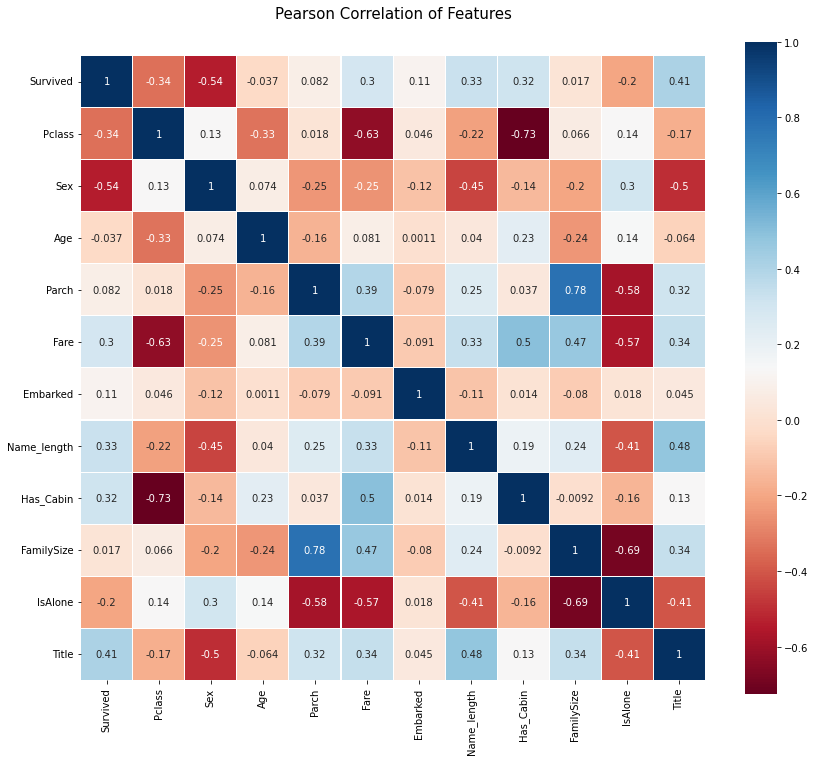

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

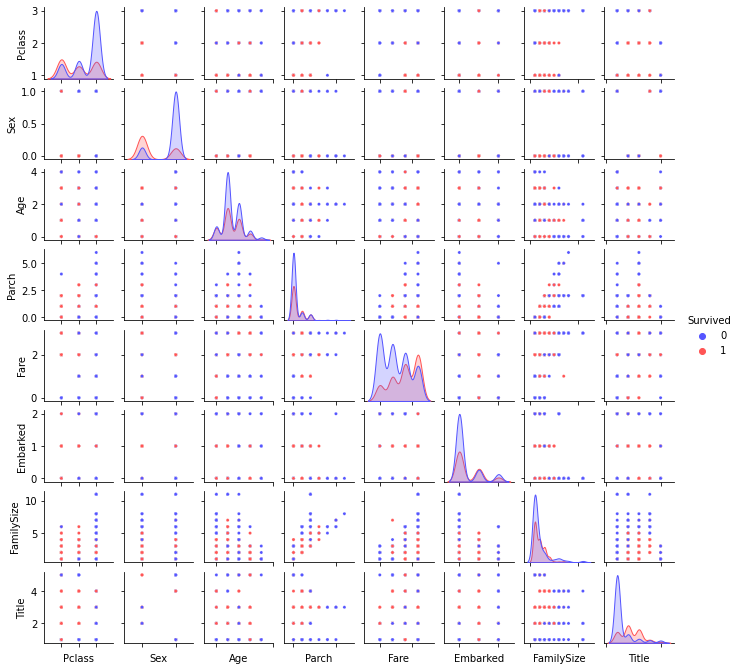

In [8]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [9]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

In [10]:
targets = train.Survived
data = train.drop(columns='Survived')

x_train, valid, y_train, valid_true = train_test_split(data, 
                                                    targets,
                                                    test_size=0.3,
                                                    random_state=17)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [11]:
# ваш код
gbc = GradientBoostingClassifier(random_state=17)
clf_gbc = GridSearchCV(gbc, gbc_params, cv = skf)

rfc = RandomForestClassifier(random_state=17)
clf_rfc = GridSearchCV(rfc, rfc_params, cv = skf)

svc = SVC(random_state=17)
clf_svc = GridSearchCV(svc, svc_params, cv = skf)

lr = LogisticRegression(random_state=17)
clf_lr = GridSearchCV(lr, lr_params, cv = skf)


In [12]:
model_gbc = clf_gbc.fit(x_train, y_train)
model_rfc = clf_rfc.fit(x_train, y_train)
model_svc = clf_svc.fit(x_train, y_train)
model_lr = clf_lr.fit(x_train, y_train)


In [13]:
print(f'gbc_best_params_: {clf_gbc.best_params_}')
print(f'rfc_best_params_: {clf_rfc.best_params_}')
print(f'svc_best_params_: {clf_svc.best_params_}')
print(f'lr_best_params_: {clf_lr.best_params_}')

gbc_best_params_: {'learning_rate': 0.2}
rfc_best_params_: {'min_samples_leaf': 4, 'n_estimators': 80}
svc_best_params_: {'C': 0.30000000000000004, 'kernel': 'linear'}
lr_best_params_: {'C': 0.7}


In [14]:
pred_gbc = clf_gbc.predict(valid)
pred_rfc = clf_rfc.predict(valid)
pred_svc = clf_svc.predict(valid)
pred_lr = clf_lr.predict(valid)

In [15]:
from sklearn.metrics import recall_score
print(f'recall_gbc: {recall_score(valid_true, pred_gbc)}')
print(f'recall_rfc: {recall_score(valid_true, pred_rfc)}')
print(f'recall_svc: {recall_score(valid_true, pred_svc)}')
print(f'recall_lr: {recall_score(valid_true, pred_lr)}')


recall_gbc: 0.6756756756756757
recall_rfc: 0.6486486486486487
recall_svc: 0.6846846846846847
recall_lr: 0.7027027027027027


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [16]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [17]:
# ваш код
import xgboost as xgb
from xgboost import XGBClassifier
# матрица метапризнаков
predictions = [pred_gbc, pred_rfc, pred_svc, pred_lr]
meta_mtrx = np.empty((valid.shape[0], len(predictions)))

for n, prediction in enumerate(predictions):
    meta_mtrx[:, n] = prediction

# настройка параметров алгоритма
xgb = XGBClassifier(random_state=17)
clf_xgb = GridSearchCV(xgb, xgb_params, cv = skf, n_jobs = -1, verbose = True)

model_xgb = clf_xgb.fit(meta_mtrx, valid_true)
print(f'xgb_best_params_: {clf_xgb.best_params_}')


Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1730 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2282 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3258 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4008 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4858 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 6858 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8008 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 9258 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 10608 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 12058 tasks     

[13:26:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb_best_params_: {'eta': 0.1, 'min_child_weight': 2, 'n_estimators': 10, 'subsample': 0.9000000000000001}


### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [18]:
# ваш код
from sklearn.model_selection import cross_val_predict

gbc1 = GradientBoostingClassifier(learning_rate=0.2, random_state=17)
rfc1 = RandomForestClassifier(min_samples_leaf=4, n_estimators=80, random_state=17)
svc1 = SVC(C=0.3, kernel='linear', random_state=17)
lr1 = LogisticRegression(C=0.7, random_state=17)
xgb1 = XGBClassifier(eta=0.1, min_child_weight=2, n_estimators=10, subsample=0.9, random_state = 17, eval_metric = 'logloss')

models = [gbc1, rfc1, svc1, lr1]



In [19]:
meta_mtrx = np.empty((data.shape[0], len(models)))
for n, model in enumerate(models):
    meta_mtrx[:, n] = cross_val_predict(model, data, targets, cv=5, method='predict')
    model.fit(data, targets)
            
xgb1.fit(meta_mtrx, targets)
        
meta_mtrx_test = np.empty((test.shape[0], len(models)))
        
for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test)
    
meta_predictions = xgb1.predict(meta_mtrx_test)



### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [20]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [23]:
write_to_submission_file(meta_predictions, PassengerId)

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ:

0.78708